<a href="https://colab.research.google.com/github/gonzaq94/NER-LLM-classification/blob/main/Copie_de_fine_tune_BERT_doc_level_annots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import comet_ml
import comet_llm
import os
import gdown
from datasets import load_dataset, concatenate_datasets
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from openai import OpenAI
import seaborn as sns

# Download and augment dataset with GPT

In [ ]:
# Load the CONLL dataset
dataset_train = load_dataset("conll2003", split="train").shuffle().select(range(1000))
dataset_valid = load_dataset("conll2003", split="validation").shuffle().select(range(1000))

In [ ]:
dataset_test = load_dataset("conll2003", split="test")

In [ ]:
client = OpenAI(api_key=OPEN_AI_API_KEY)

# Function to classify a document
def classify_document(document_text):

    prompt = f"""
    You are an AI document classifier. Please classify the following document into one of the following categories: World, Sport, Business, Technology, Other.

    Document:
    "{document_text}"

    Category:
    """

    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="gpt-4o-mini",
        max_tokens=10,  # Only need a few tokens for the category response
        temperature=0  # Lower temperature for deterministic results
    )

    return response.choices[0].message.content

# Classify some example documents

for i in range(5):

  example = " ".join(dataset_train[i]['tokens'])

  category = classify_document(example)

  print(f"Example {i}:", example)
  print("Classification:", category)
  print()


Example 0: DETROIT 46 82 .359 27 1/2
Classification: Other

Example 1: Masterkova dominated the middle-distance races at the recent Atlanta Games following her return to competition this season after a three-year maternity break .
Classification: Sport

Example 2: The area is filled with treacherous mountain peaks , ice fields and frigid waters .
Classification: Other

Example 3: " The premium will be no lower than 15 percent and will be set by management before the issue ...
Classification: Business

Example 4: DUBAI 1996-08-29
Classification: Other



## Augment all dataset with document-level annotations

In [ ]:
doc_label_dct = {"World": 0, "Sport": 1, "Business": 2, "Technology": 3, "Other": 4}

def add_document_label(row):

    text = " ".join(row['tokens'])
    doc_label = classify_document(text)
    row["doc_labels"] = doc_label_dct[doc_label.lstrip("Category: ")]

    return row

In [ ]:
dataset_train_augmented = dataset_train.map(add_document_label)
dataset_valid_augmented = dataset_valid.map(add_document_label)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
dataset_test_augmented = dataset_test.map(add_document_label)

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

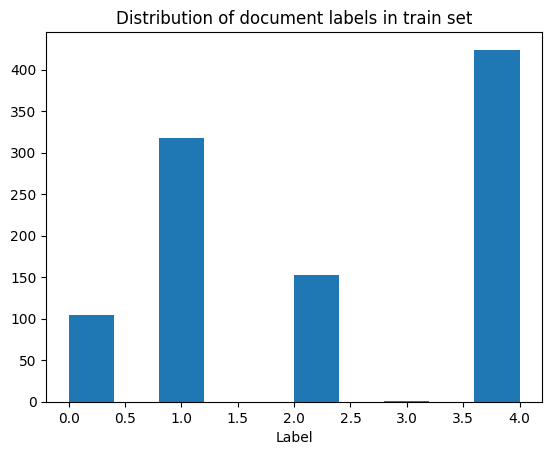

In [ ]:
plt.hist(dataset_train_augmented['doc_labels'])
plt.title('Distribution of document labels in train set')
plt.xlabel('Label')
plt.show()

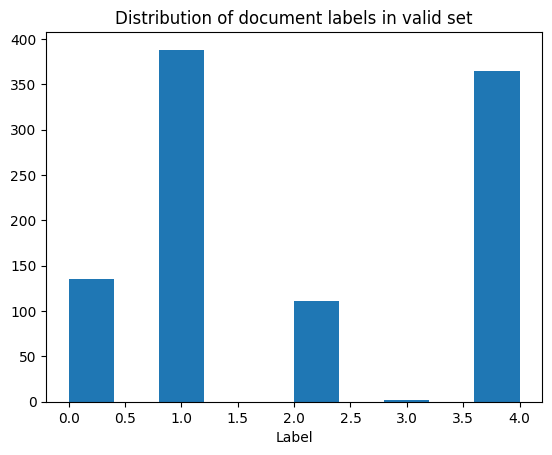

In [ ]:
plt.hist(dataset_valid_augmented['doc_labels'])
plt.title('Distribution of document labels in valid set')
plt.xlabel('Label')
plt.show()

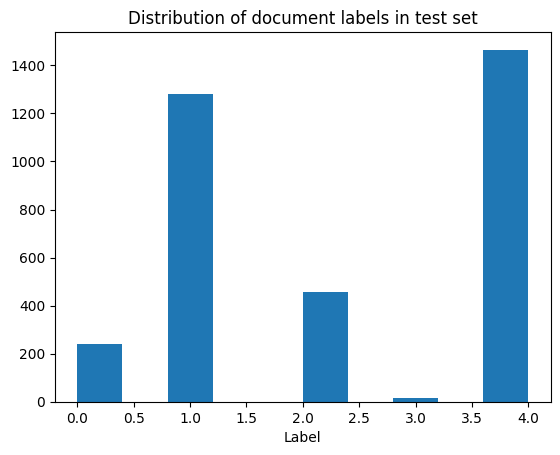

In [ ]:
plt.hist(dataset_test_augmented['doc_labels'])
plt.title('Distribution of document labels in test set')
plt.xlabel('Label')
plt.show()

In [ ]:
# Save the dataset to a directory
dataset_train_augmented.save_to_disk("/content/drive/My Drive/Colab Notebooks/conll2003_train_augmented_1k")
dataset_valid_augmented.save_to_disk("/content/drive/My Drive/Colab Notebooks/conll2003_valid_augmented_1k")
dataset_test_augmented.save_to_disk("/content/drive/My Drive/Colab Notebooks/conll2003_test_augmented")

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3453 [00:00<?, ? examples/s]

# Create a balanced augmented

In [ ]:
# Load the CONLL dataset
dataset_train = load_dataset("conll2003", split="train")
dataset_valid = load_dataset("conll2003", split="validation")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [ ]:
client = OpenAI(api_key=OPEN_AI_API_KEY)

# Function to classify a document
def classify_document(document_text):

    prompt = f"""
    You are an AI document classifier. Please classify the following document into one of the following categories: World, Sport, Business, Technology, Other.

    Document:
    "{document_text}"

    Category:
    """

    response = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": prompt,
            }
        ],
        model="gpt-4o-mini",
        max_tokens=10,  # Only need a few tokens for the category response
        temperature=0  # Lower temperature for deterministic results
    )

    return response.choices[0].message.content

doc_label_dct = {"World": 0, "Sport": 1, "Business": 2, "Technology": 3, "Other": 4}

def add_document_label(row):

    text = " ".join(row['tokens'])
    doc_label = classify_document(text)
    row["doc_labels"] = doc_label_dct[doc_label.lstrip("Category: ")]

    return row

In [ ]:
#dataset_train_augmented = dataset_train.map(add_document_label)
dataset_valid_augmented = dataset_valid.map(add_document_label)

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

In [ ]:
# Save the dataset to a directory
#dataset_train_augmented.save_to_disk("/content/drive/My Drive/Colab Notebooks/conll2003_train_augmented")
dataset_valid_augmented.save_to_disk("/content/drive/My Drive/Colab Notebooks/conll2003_valid_augmented")

Saving the dataset (0/1 shards):   0%|          | 0/3250 [00:00<?, ? examples/s]

In [ ]:
print(dataset_train_augmented[0])

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0], 'doc_labels': 2}


In [ ]:
plt.hist(dataset_train_augmented['doc_labels'])
plt.title('Distribution of document labels in train set')
plt.xlabel('Label')
plt.show()

# Download previously augmented dataset

In [ ]:
from datasets import load_from_disk

loaded_train_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_train_augmented")
loaded_valid_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_valid_augmented")
loaded_test_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_test_augmented")

In [ ]:
print("train:", loaded_train_dataset)
print("valid:", loaded_valid_dataset)
print("test:", loaded_test_dataset)

train: Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'doc_labels'],
    num_rows: 14041
})
valid: Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'doc_labels'],
    num_rows: 3250
})
test: Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'doc_labels'],
    num_rows: 3453
})


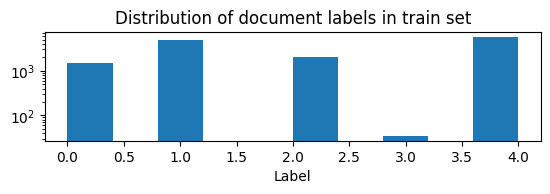

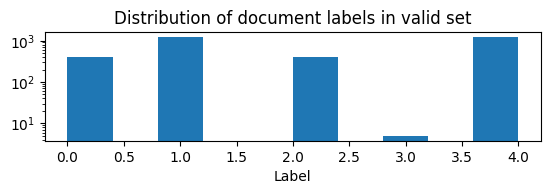

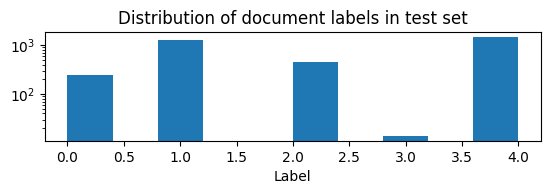

In [ ]:
plt.subplot(3,1,1)
plt.hist(loaded_train_dataset['doc_labels'])
plt.title('Distribution of document labels in train set')
plt.xlabel('Label')
plt.yscale('log')
plt.show()

plt.subplot(3,1,2)
plt.hist(loaded_valid_dataset['doc_labels'])
plt.title('Distribution of document labels in valid set')
plt.xlabel('Label')
plt.yscale('log')
plt.show()

plt.subplot(3,1,3)
plt.hist(loaded_test_dataset['doc_labels'])
plt.title('Distribution of document labels in test set')
plt.xlabel('Label')
plt.yscale('log')
plt.show()

## Downsample in a stratified fashion


In [ ]:
# train set
train_dataset_cls_3 = loaded_train_dataset.filter(lambda example: example['doc_labels'] == 3)
downsampled_loaded_train_dataset = loaded_train_dataset.filter(lambda example: example['doc_labels'] != 3).shuffle().select(range(1000-len(train_dataset_cls_3)))
combined_train_dataset = concatenate_datasets([train_dataset_cls_3, downsampled_loaded_train_dataset])

# valid set
valid_dataset_cls_3 = loaded_valid_dataset.filter(lambda example: example['doc_labels'] == 3)
downsampled_loaded_valid_dataset = loaded_valid_dataset.filter(lambda example: example['doc_labels'] != 3).shuffle().select(range(1000-len(valid_dataset_cls_3)))
combined_valid_dataset = concatenate_datasets([train_dataset_cls_3, downsampled_loaded_valid_dataset])

Filter:   0%|          | 0/3250 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3250 [00:00<?, ? examples/s]

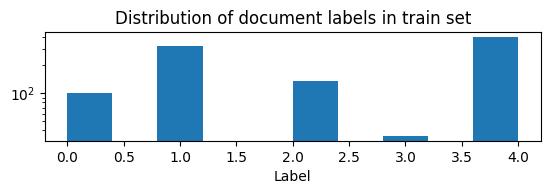

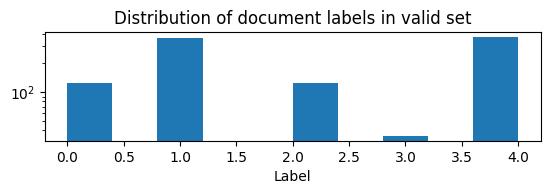

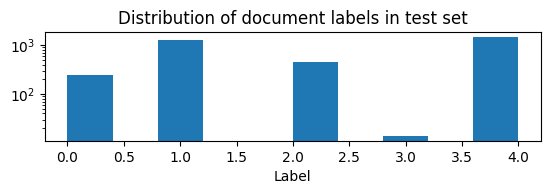

In [ ]:
plt.subplot(3,1,1)
plt.hist(combined_train_dataset['doc_labels'])
plt.title('Distribution of document labels in train set')
plt.xlabel('Label')
plt.yscale('log')
plt.show()

plt.subplot(3,1,2)
plt.hist(combined_valid_dataset['doc_labels'])
plt.title('Distribution of document labels in valid set')
plt.xlabel('Label')
plt.yscale('log')
plt.show()

plt.subplot(3,1,3)
plt.hist(loaded_test_dataset['doc_labels'])
plt.title('Distribution of document labels in test set')
plt.xlabel('Label')
plt.yscale('log')
plt.show()

In [ ]:
# Save the dataset to a directory
combined_train_dataset.save_to_disk("/content/drive/My Drive/Colab Notebooks/conll2003_train_augmented_1k_strat")
combined_valid_dataset.save_to_disk("/content/drive/My Drive/Colab Notebooks/conll2003_valid_augmented_1k_strat")

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1030 [00:00<?, ? examples/s]

## Prepare data

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = " ".join(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label)
        }


In [ ]:
train_custom_dataset = CustomDataset(
    texts=loaded_train_dataset['tokens'],
    labels=loaded_train_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

valid_custom_dataset = CustomDataset(
    texts=loaded_valid_dataset['tokens'],
    labels=loaded_valid_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

# Fine-tune model

In [ ]:
# log results and assets to Comet
os.environ["COMET_LOG_ASSETS"] = "True"
os.environ["COMET_WORKSPACE"] = "gonzaq94"
os.environ["COMET_PROJECT_NAME"] = "ner_classif-bert-doc_level_annots"

In [ ]:
doc_label_dct = {"World": 0, "Sport": 1, "Business": 2, "Technology": 3, "Other": 4}

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=len(doc_label_dct),
                                                           attention_probs_dropout_prob=0.0,
                                                           hidden_dropout_prob=0.0)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Get the predicted class indices
    true_predictions = [p for (p, l) in zip(predictions.flatten(), labels.flatten()) if l != -100]
    true_labels = [l for l in labels.flatten() if l != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=1 )
    acc = accuracy_score(true_labels, true_predictions)


    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
experiment = comet_ml.Experiment(api_key=os.getenv("COMET_API_KEY"), project_name=os.getenv("COMET_PROJECT_NAME"), workspace=os.getenv("COMET_WORKSPACE"))

# Define a custom callback to ensure experiment.end() is called
class CometCallback(TrainerCallback):
    def __init__(self, experiment):
        self.experiment = experiment

    def on_train_end(self, args, state, control, **kwargs):
        self.experiment.end()  # Ends the experiment properly when training ends

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=16,
    warmup_steps=63,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir=None,
    dataloader_drop_last=False,
    fp16=True, # mixed precision
    report_to=["comet_ml"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_custom_dataset,
    eval_dataset=valid_custom_dataset,
    compute_metrics=compute_metrics,
    callbacks=[CometCallback(experiment)]
)


In [ ]:
trainer.train()

In [ ]:
for elem in train_custom_dataset:
  print(elem['input_ids'].size())
  break

## Evaluate model

In [ ]:
def plot_confusion_matrix(cm, class_names):

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def compute_metrics_eval(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Get the predicted class indices
    true_predictions = [p for (p, l) in zip(predictions.flatten(), labels.flatten()) if l != -100]
    true_labels = [l for l in labels.flatten() if l != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=1 )
    acc = accuracy_score(true_labels, true_predictions)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, true_predictions, normalize='true')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix
    }


class Evaluator:
    def __init__(self, model, tokenizer, compute_metrics):
        self.model = model
        self.tokenizer = tokenizer
        self.compute_metrics = compute_metrics

    def evaluate(self, eval_dataset, batch_size=16):
        trainer = Trainer(
            model=self.model,
            args=training_args,
            compute_metrics=self.compute_metrics,
            eval_dataset=eval_dataset,
        )
        return trainer.evaluate()

In [ ]:
evaluator = Evaluator(model, tokenizer, compute_metrics_eval)
eval_results = evaluator.evaluate(valid_custom_dataset)

In [ ]:
doc_label_dct = {"World": 0, "Sport": 1, "Business": 2, "Technology": 3, "Other": 4}
class_names = [k for k, v in doc_label_dct.items()]
plot_confusion_matrix(eval_results['eval_confusion_matrix'], class_names)

# Fine-tune stratified data

In [ ]:
from datasets import load_from_disk

loaded_train_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_train_augmented_1k_strat")
loaded_valid_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_valid_augmented_1k_strat")
loaded_test_dataset = load_from_disk("/content/drive/My Drive/Colab Notebooks/conll2003_test_augmented")

In [ ]:
train_custom_dataset = CustomDataset(
    texts=loaded_train_dataset['tokens'],
    labels=loaded_train_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

valid_custom_dataset = CustomDataset(
    texts=loaded_valid_dataset['tokens'],
    labels=loaded_valid_dataset['doc_labels'],
    tokenizer=tokenizer,
    max_length=256
)

In [ ]:
# log results and assets to Comet
os.environ["COMET_LOG_ASSETS"] = "True"
os.environ["COMET_PROJECT_NAME"] = "ner_classif-bert-doc_level_annots-strat_data"

In [ ]:
doc_label_dct = {"World": 0, "Sport": 1, "Business": 2, "Technology": 3, "Other": 4}

model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=len(doc_label_dct),
                                                           attention_probs_dropout_prob=0.0,
                                                           hidden_dropout_prob=0.0)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  # Get the predicted class indices
    true_predictions = [p for (p, l) in zip(predictions.flatten(), labels.flatten()) if l != -100]
    true_labels = [l for l in labels.flatten() if l != -100]

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=1 )
    acc = accuracy_score(true_labels, true_predictions)


    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
experiment = comet_ml.Experiment(api_key=os.getenv("COMET_API_KEY"), project_name=os.getenv("COMET_PROJECT_NAME"), workspace=os.getenv("COMET_WORKSPACE"))

# Define a custom callback to ensure experiment.end() is called
class CometCallback(TrainerCallback):
    def __init__(self, experiment):
        self.experiment = experiment

    def on_train_end(self, args, state, control, **kwargs):
        self.experiment.end()  # Ends the experiment properly when training ends

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    per_device_train_batch_size=24,
    per_device_eval_batch_size=16,
    warmup_steps=63,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir=None,
    dataloader_drop_last=False,
    fp16=True, # mixed precision
    report_to=["comet_ml"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_custom_dataset,
    eval_dataset=valid_custom_dataset,
    compute_metrics=compute_metrics,
)


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : costly_triplex_7587
COMET INFO:     url                   : https://www.comet.com/gonzaq94/ner-classif-bert-doc-level-annots-strat-data/830ae58d5cc449bca9d115582eddf4e2
COMET INFO:   Others:
COMET INFO:     hasNestedParams : True
COMET INFO:     notebook_url    : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2Fgonzaq94%2FNER-LLM-classification%2Fblob%2Fmain%2Ffine_tune_BERT_doc_level_annots.ipynb
COMET INFO:   Parameters:
COMET INFO:     args|accelerator_config|dispatch_batches             : None
COMET INFO:     args|accelerator_config|even_batches                 : True
COMET INFO:     args|accelerator_config|gradient_ac

In [ ]:
trainer.train()

COMET INFO: An experiment with the same configuration options is already running and will be reused.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 